### IMPORTS

In [1]:
library(gplots)
library(ggplot2)
library(phylolm)
library(dplyr)
library(janitor)
#library(dplyr) #ONLY USABLE ON KERNEL THAT HAS NO PHYLOLM

Warning message:
"package 'gplots' was built under R version 4.2.3"

Attaching package: 'gplots'


The following object is masked from 'package:stats':

    lowess


Warning message:
"package 'ggplot2' was built under R version 4.2.3"
Loading required package: ape

Warning message:
"package 'ape' was built under R version 4.2.3"
Warning message:
"package 'dplyr' was built under R version 4.2.3"

Attaching package: 'dplyr'


The following object is masked from 'package:ape':

    where


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'janitor'


The following objects are masked from 'package:stats':

    chisq.test, fisher.test




### BELOW: load raw data and take sample

In [3]:
# oligo_dir <- "~/geb/data/240_predictions_MatrixStacked.tsv"
oligo_dir <- "/ocean/projects/bio240054p/shared/project/240_predictions_matrix_celltypes/Oligo/240_predictions_MatrixStacked.tsv"
oligo_peaks <- as.matrix(read.csv(file = oligo_dir, sep="\t", stringsAsFactors=F, header=T))
oligo_peaks[1:5,1:5]
dim(oligo_peaks)

hg38.chr1.826813.827314,X.1.0,X.1.0.1,X.1.0.2,X.1.0.3
hg38:chr1:1024919-1025420,-1.000000,0.706560,0.651131,0.575120
hg38:chr1:2425858-2426359,-1.000000,-1.000000,-1.000000,-1.000000
hg38:chr1:41454380-41454881,0.605298,0.506191,0.616473,0.676978
hg38:chr5:43631268-43631769,0.687959,0.539154,0.643731,0.723263
hg38:chr5:44808620-44809121,-1.000000,0.677044,0.628291,0.640640


[1] 160451    242

In [4]:
#take a random sample of 10000
oligo_peaks_randsamp <- oligo_peaks[sample(nrow(oligo_peaks), 10000),]
oligo_peaks_randsamp[1:5,1:5]
dim(oligo_peaks_randsamp)

#save this sample for later to make loading easier
write.csv(oligo_peaks_randsamp, file="big_files/oligo_randsamp.csv")

hg38.chr1.826813.827314,X.1.0,X.1.0.1,X.1.0.2,X.1.0.3
mm10:chr4:116074601-116075102,0.523779,0.598974,0.595557,0.571499
hg38:chr19:2332088-2332589,0.562492,-1.000000,0.597956,0.810578
rheMac10:chr18:49962409-49962909:250,0.561874,0.481355,-1.000000,0.765442
mm10:chr11:58981901-58982402,-1.000000,0.445124,0.620768,0.596671
rn6:chr5:147815160-147815660:250,0.485449,0.454665,0.575763,0.519272


[1] 10000   242

### DATA PROCESSING: USES DPLYR

In [2]:
#load random sample back in for future runs
oligo_peaks_randsamp <- as.matrix(read.csv("big_files/oligo_randsamp.csv"))

#split by species of interest: hypselodonts vs non-hypselodonts
#first rename the columns to the species given in the text file
names <- readLines(con = "240_predictions_NamesList.txt")
names <- c("", "Region", names)

colnames(oligo_peaks_randsamp) <- names

#first get list of hypselodonts
#this dataframe was made using the phenotype information data
hyps_data <- read.csv("hypselodonts_known.csv")

hyps <- hyps_data %>% filter(Hypselodonty == 1)
nonhyps <- hyps_data %>% filter(Hypselodonty == 0)

hyps_names <- hyps$Name
nonhyps_names <- nonhyps$Name

#now we can select hypselodonts
hyps_oligo_peaks <- as.data.frame(oligo_peaks_randsamp) %>% select(any_of(hyps_names))

rownames(hyps_oligo_peaks) <- oligo_peaks_randsamp[,"Region"]
#hyps_oligo_peaks[1:5, 1:5]
dim(hyps_oligo_peaks)

nonhyps_oligo_peaks <- as.data.frame(oligo_peaks_randsamp) %>% select(any_of(nonhyps_names))
rownames(nonhyps_oligo_peaks) <- oligo_peaks_randsamp[,"Region"]
#nonhyps_oligo_peaks[1:5, 1:5]
dim(nonhyps_oligo_peaks)

[1] 10000    63

[1] 10000   146

### PART 2: OPEN CHROMATIN DIFFERENCES

In [3]:
#code to do this part borrowed from HW2
diffPvaluesV <- rep(NA,nrow(hyps_oligo_peaks)); #Create an empty vector to store the p-values per open chromatin region in
names(diffPvaluesV) <- rownames(hyps_oligo_peaks); #Name that vector with the peak names
diffMeansV <- diffPvaluesV #Create a new vector, also empty, to store the differences across species

#modified to do hypselodonts
peak_ids <- rownames(hyps_oligo_peaks)
for(curPeak in peak_ids) { #Loop through each of the peaks
  hypVals <- as.numeric(hyps_oligo_peaks[curPeak,]); #For that peak get the HYPSELODONT predicitons
  nonHypVals <- as.numeric(nonhyps_oligo_peaks[curPeak,]); #For that peak get the NON-HYPSELODONT predicitons
    if(sd(hypVals,na.rm=T) > 0 && sd(nonHypVals,na.rm=T) > 0) { #Ensure that standard deviation greater than 0
      curTtest <- t.test(x=hypVals,y=nonHypVals);
      diffPvaluesV[curPeak] <- curTtest$p.value
      diffMeansV[curPeak] <- mean(hypVals,na.rm=T) - mean(nonHypVals,na.rm=T);
    }
}

diffResultsF <- data.frame(id=peak_ids, meanDiff=diffMeansV, pvalue=diffPvaluesV, padj = p.adjust(diffPvaluesV))
diffResultsSortF <- diffResultsF[order(diffResultsF$padj),]
diffResultsSortF[1:10,]

,id,meanDiff,pvalue,padj
,<chr>,<dbl>,<dbl>,<dbl>
rheMac10:chr11:2941186-2941686:250,rheMac10:chr11:2941186-2941686:250,-1.232176,4.690293e-42,4.526133e-38
rheMac10:chr19:6413930-6414430:250,rheMac10:chr19:6413930-6414430:250,-1.084471,1.008412e-39,9.730163e-36
hg38:chr18:49250780-49251281,hg38:chr18:49250780-49251281,-1.193157,1.209898e-35,1.167310e-31
hg38:chr22:18024859-18025360,hg38:chr22:18024859-18025360,-1.045510,1.905615e-35,1.838347e-31
hg38:chr10:97701307-97701808,hg38:chr10:97701307-97701808,-1.030745,4.992684e-35,4.815943e-31
rheMac10:chr1:215554283-215554783:250,rheMac10:chr1:215554283-215554783:250,-1.116329,9.383476e-35,9.050363e-31
rheMac10:chr6:36509743-36510243:250,rheMac10:chr6:36509743-36510243:250,-1.301959,1.479052e-34,1.426398e-30
rheMac10:chr1:16061783-16062283:250,rheMac10:chr1:16061783-16062283:250,-1.180413,4.586443e-34,4.422707e-30
rheMac10:chr15:10896968-10897468:250,rheMac10:chr15:10896968-10897468:250,-1.232194,4.930198e-34,4.753697e-30


#### USING PHYLOLM: REQUIRES NEW KERNEL WITHOUT DPLYR
I honestly think the results are similar to using the t-test but we will do this anyway.

In [4]:
#modify the data so that the variables are on the top, animals on the side, add hypselodonty
library(tidyr)
hypsTemp <- t(hyps_oligo_peaks)
hypsTemp <- as.data.frame(hypsTemp)
hypsTemp <- hypsTemp %>% mutate(Hypselodont = 1)

nonhypsTemp <- t(nonhyps_oligo_peaks)
nonhypsTemp <- as.data.frame(nonhypsTemp)
nonhypsTemp <- nonhypsTemp %>% mutate(Hypselodont = 0)

combined_hyp_peaks <- bind_rows(hypsTemp, nonhypsTemp)
combined_hyp_peaks[1:5, 1:5]
dim(combined_hyp_peaks)

#write this as csv so that we can read it in to do phylolm
write.csv(combined_hyp_peaks, file="big_files/hyps_oligo_peaks.csv")

Warning message:
"package 'tidyr' was built under R version 4.2.3"


,mm10:chr4:116074601-116075102,hg38:chr19:2332088-2332589,rheMac10:chr18:49962409-49962909:250,mm10:chr11:58981901-58982402,rn6:chr5:147815160-147815660:250
,<chr>,<chr>,<chr>,<chr>,<chr>
Acomys_cahirinus,0.598974,-1.000000,0.481355,0.445124,0.454665
Allactaga_bullata,-1.000000,0.625038,-1.000000,0.462216,0.418158
Aplodontia_rufa,0.476708,-1.000000,0.296134,0.694202,0.609698
Castor_canadensis,0.743637,0.381529,-1.000000,0.810445,0.294313
Catagonus_wagneri,0.684707,0.572286,0.700693,-1.000000,0.453264


[1]   209 10001

In [5]:
library(phylolm)
zoonomiaTree <- read.tree(file = "Zoonomia_ChrX_lessGC40_241species_30Consensus.tree")

#load in data from earlier:
#opc_peaks_randsamp <- as.matrix(read.csv("~/geb/data/opc_randsamp.csv"))
#combined_hyp_peaks <- read.csv("~/geb/data/hyps_opc_peaks.csv")
#combined_hyp_peaks[1:5,1:5]

combined_hyp_peaks <- clean_names(combined_hyp_peaks)
peakNames <- colnames(combined_hyp_peaks)
peakNames <- peakNames[! peakNames %in% c('hypselodont')]
peakNames[1:5]

Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00C4>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00D6>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00DC>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00E4>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00F6>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00FC>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00DF>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00C6>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00E6>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00D8>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00F8>' to native encoding"
Warning message in FU

[1] "mm10_chr4_116074601_116075102"        
[2] "hg38_chr19_2332088_2332589"           
[3] "rhe_mac10_chr18_49962409_49962909_250"
[4] "mm10_chr11_58981901_58982402"         
[5] "rn6_chr5_147815160_147815660_250"

In [6]:
# read in the hyps_oligo_peaks data
PvaluesPHY <- rep(NA,nrow(hyps_oligo_peaks))
names(PvaluesPHY) <- rownames(hyps_oligo_peaks)
corrsPHY <- PvaluesPHY
slopesPHY <- PvaluesPHY

curIndex = 1

for(curPeak in peakNames) {
    peakLmFit <- phylolm(as.numeric(combined_hyp_peaks[,curIndex]) ~ hypselodont, 
                         data=combined_hyp_peaks, 
                         phy=zoonomiaTree, model="BM")
    peakLmFitSum <- summary(peakLmFit)
    
    PvaluesPHY[curPeak] <- peakLmFitSum$coefficients[8]
    slopesPHY[curPeak] <- peakLmFitSum$coefficients[2]
    #print(peakLmFitSum$coefficients[8])
    corrsPHY[curPeak] <- peakLmFitSum$adj.r.squared
    curIndex <- curIndex + 1
}

phyloRes <- data.frame(id=peakNames, r_squared_adj=corrsPHY,
                       effect_size=slopesPHY,pvalue=PvaluesPHY, 
                       padj = p.adjust(PvaluesPHY))
phyloRes <- phyloRes[order(phyloRes$padj),]
phyloRes[1:10,]

write.csv(phyloRes, file="phyloRes.csv")

Warning message in phylolm(as.numeric(combined_hyp_peaks[, curIndex]) ~ hypselodont, :
"will drop from the tree 32 taxa with missing data"
Warning message in phylolm(as.numeric(combined_hyp_peaks[, curIndex]) ~ hypselodont, :
"will drop from the tree 32 taxa with missing data"
Warning message in phylolm(as.numeric(combined_hyp_peaks[, curIndex]) ~ hypselodont, :
"will drop from the tree 32 taxa with missing data"
Warning message in phylolm(as.numeric(combined_hyp_peaks[, curIndex]) ~ hypselodont, :
"will drop from the tree 32 taxa with missing data"
Warning message in phylolm(as.numeric(combined_hyp_peaks[, curIndex]) ~ hypselodont, :
"will drop from the tree 32 taxa with missing data"
Warning message in phylolm(as.numeric(combined_hyp_peaks[, curIndex]) ~ hypselodont, :
"will drop from the tree 32 taxa with missing data"
Warning message in phylolm(as.numeric(combined_hyp_peaks[, curIndex]) ~ hypselodont, :
"will drop from the tree 32 taxa with missing data"
Warning message in phylolm(

,id,r_squared_adj,effect_size,pvalue,padj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
rn6_chr7_2826949_2827449_250,rn6_chr7_2826949_2827449_250,0.2971102,-0.9628657,8.629997e-18,8.629997e-14
mm10_chr_x_136828556_136829057,mm10_chr_x_136828556_136829057,0.2554094,-1.0312658,3.613072e-15,3.612711e-11
rn6_chr7_135713270_135713770_250,rn6_chr7_135713270_135713770_250,0.2093691,-0.8694636,1.974092e-12,1.973697e-08
rn6_chr17_63675352_63675852_250,rn6_chr17_63675352_63675852_250,0.1955062,-0.8900148,1.231941e-11,1.231571e-07
hg38_chr1_8815512_8816013,hg38_chr1_8815512_8816013,0.1792298,-0.7694455,1.019733e-10,1.019325e-06
rhe_mac10_chr6_144494360_144494860_250,rhe_mac10_chr6_144494360_144494860_250,0.1701882,-0.9465484,3.245978e-10,3.244355e-06
mm10_chr7_134534857_134535358,mm10_chr7_134534857_134535358,0.1685936,-1.1373558,3.976775e-10,3.974389e-06
hg38_chr1_18922280_18922781,hg38_chr1_18922280_18922781,0.1672758,-0.8317355,4.702104e-10,4.698813e-06
rn6_chr1_170577738_170578238_250,rn6_chr1_170577738_170578238_250,0.1636539,-0.8964390,7.443124e-10,7.437169e-06


In [7]:
library(patchwork)
library(gridExtra)


Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 10000 rows containing non-finite outside the scale range
(`stat_bin()`)."
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 10000 rows containing non-finite outside the scale range
(`stat_bin()`)."
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 350 rows containing non-finite outside the scale range (`stat_bin()`)."
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 350 rows containing non-finite outside the scale range (`stat_bin()`)."


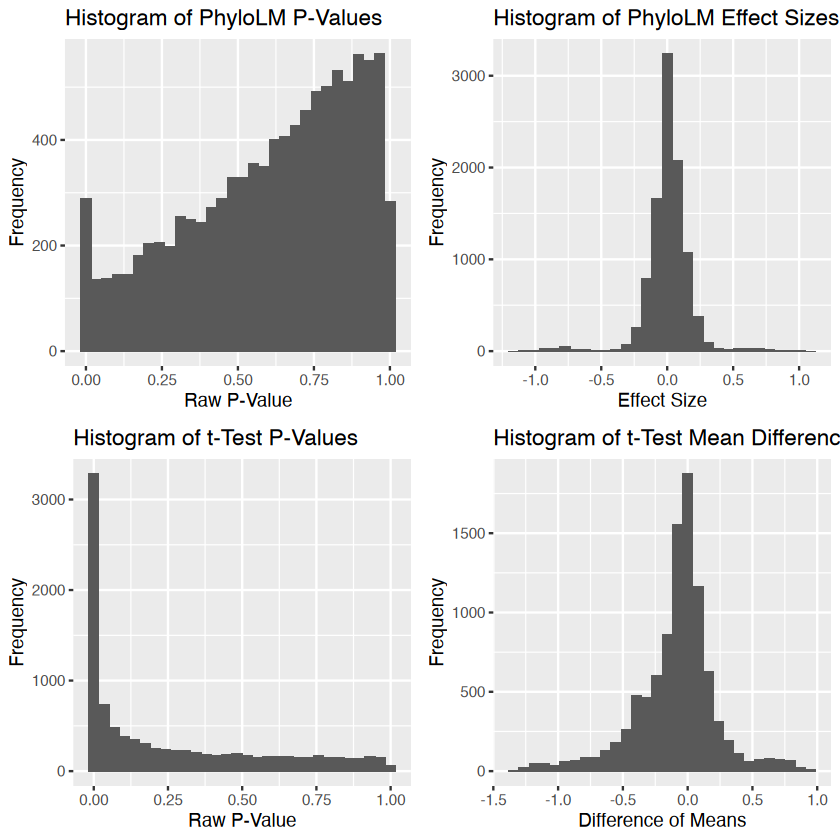

In [8]:
#t-test results
p1 <- ggplot(data = diffResultsSortF, aes(x=pvalue)) +
    geom_histogram() +
    labs(x = "Raw P-Value",
         y = "Frequency",
         title = "Histogram of t-Test P-Values")

p2 <- ggplot(data = diffResultsSortF, aes(x=meanDiff)) +
    geom_histogram() +
    labs(x = "Difference of Means",
         y = "Frequency",
         title = "Histogram of t-Test Mean Differences")

#phyloLM results
p3 <- ggplot(data = phyloRes, aes(x=pvalue)) +
    geom_histogram() +
    labs(x = "Raw P-Value",
         y = "Frequency",
         title = "Histogram of PhyloLM P-Values")

p4 <- ggplot(data = phyloRes, aes(x=effect_size)) +
    geom_histogram() +
    labs(x = "Effect Size",
         y = "Frequency",
         title = "Histogram of PhyloLM Effect Sizes")

# (p1 | p2) / (p3 | p4)
grid.arrange(p3, p4, p1, p2, ncol = 2, heights = c(10, 10), widths = c(10, 10))

In [9]:
#finding most positively and negatively associated peak
#first with PhyloLM, using pos/neg slope. 
phyloResPos <- phyloRes %>% filter(effect_size > 0)
phyloResNeg <- phyloRes %>% filter(effect_size < 0)
phyloResPos[1:5,]
phyloResNeg[1:5,]

,id,r_squared_adj,effect_size,pvalue,padj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
rhe_mac10_chr1_89224917_89225417_250,rhe_mac10_chr1_89224917_89225417_250,0.1564539,1.0239465,1.845237e-09,1.843207e-05
rn6_chr17_4696685_4697185_250,rn6_chr17_4696685_4697185_250,0.1464345,0.7138021,6.456040e-09,6.447001e-05
hg38_chr4_77203544_77204045,hg38_chr4_77203544_77204045,0.1400196,1.1114607,1.430164e-08,1.427447e-04
hg38_chr15_85037620_85038121,hg38_chr15_85037620_85038121,0.1309344,0.7296377,4.375004e-08,4.364942e-04
rhe_mac10_chr10_67709120_67709620_250,rhe_mac10_chr10_67709120_67709620_250,0.1225515,0.7929089,1.217408e-07,1.213877e-03


,id,r_squared_adj,effect_size,pvalue,padj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
rn6_chr7_2826949_2827449_250,rn6_chr7_2826949_2827449_250,0.2971102,-0.9628657,8.629997e-18,8.629997e-14
mm10_chr_x_136828556_136829057,mm10_chr_x_136828556_136829057,0.2554094,-1.0312658,3.613072e-15,3.612711e-11
rn6_chr7_135713270_135713770_250,rn6_chr7_135713270_135713770_250,0.2093691,-0.8694636,1.974092e-12,1.973697e-08
rn6_chr17_63675352_63675852_250,rn6_chr17_63675352_63675852_250,0.1955062,-0.8900148,1.231941e-11,1.231571e-07
hg38_chr1_8815512_8816013,hg38_chr1_8815512_8816013,0.1792298,-0.7694455,1.019733e-10,1.019325e-06


In [10]:
#t-tests now
tResPos <- diffResultsSortF %>% filter(meanDiff > 0)
tResNeg <- diffResultsSortF %>% filter(meanDiff < 0)
tResNeg[1:5,]
tResPos[1:5,]

,id,meanDiff,pvalue,padj
,<chr>,<dbl>,<dbl>,<dbl>
rheMac10:chr11:2941186-2941686:250,rheMac10:chr11:2941186-2941686:250,-1.232176,4.690293e-42,4.526133e-38
rheMac10:chr19:6413930-6414430:250,rheMac10:chr19:6413930-6414430:250,-1.084471,1.008412e-39,9.730163e-36
hg38:chr18:49250780-49251281,hg38:chr18:49250780-49251281,-1.193157,1.209898e-35,1.167310e-31
hg38:chr22:18024859-18025360,hg38:chr22:18024859-18025360,-1.045510,1.905615e-35,1.838347e-31
hg38:chr10:97701307-97701808,hg38:chr10:97701307-97701808,-1.030745,4.992684e-35,4.815943e-31


,id,meanDiff,pvalue,padj
,<chr>,<dbl>,<dbl>,<dbl>
rheMac10:chr7:165233484-165233984:250,rheMac10:chr7:165233484-165233984:250,0.9718250,1.189600e-20,1.127978e-16
rn6:chr1:212231231-212231731:250,rn6:chr1:212231231-212231731:250,0.9139836,2.254660e-20,2.136516e-16
rheMac10:chr14:12410130-12410630:250,rheMac10:chr14:12410130-12410630:250,0.9456368,2.968805e-20,2.812052e-16
hg38:chr19:30419769-30420270,hg38:chr19:30419769-30420270,0.9540028,4.836197e-19,4.574075e-15
rn6:chr5:107716242-107716742:250,rn6:chr5:107716242-107716742:250,0.9515678,2.716886e-18,2.564197e-14


In [11]:
#barplots
# combined_hyp_peaks <- read.csv("~/geb/data/hyps_opc_peaks_clean.csv")
# ggplot(data = combined_hyp_peaks, aes(x = as.factor(hypselodont),
#                                       y = as.numeric(rhe_mac10_chr1_207215838_207216338_250))) +
#   geom_boxplot() +
#   labs(x = "Hypselodonty Status",
#        y = "Peak Value of Interest",
#        title = "rhe_mac10_chr1_207215838_207216338_250")

# ggplot(data = combined_hyp_peaks, aes(x = as.factor(hypselodont),
#                                       y = as.numeric(mm10_chr4_111545923_111546424))) +
#   geom_boxplot() +
#   labs(x = "Hypselodonty Status",
#        y = "Peak Value of Interest",
#        title = "mm10_chr4_111545923_111546424")

# ggplot(data = combined_hyp_peaks, aes(x = as.factor(hypselodont),
#                                       y = as.numeric(hg38_chr9_132192625_132193126))) +
#   geom_boxplot() +
#   labs(x = "Hypselodonty Status",
#        y = "Peak Value of Interest",
#        title = "hg38_chr9_132192625_132193126")

# ggplot(data = combined_hyp_peaks, aes(x = as.factor(hypselodont),
#                                       y = as.numeric(rhe_mac10_chr14_94018099_94018599_250))) +
#   geom_boxplot() +
#   labs(x = "Hypselodonty Status",
#        y = "Peak Value of Interest",
#        title = "rheMac10_chr14_94018099_94018599_250")

#get the top 200 entries of phyloResPos and Neg
phyloResPosTop <- phyloResPos[1:200,]
phyloResNegTop <- phyloResNeg[1:200,]

#prepare to write to a bed file
#editing of the bed file into proper format is done in a separate Jupyter notebook with python
write.table(phyloResPos$id, file="phyloResPosTop.bed", sep="\t", row.names=FALSE, col.names=FALSE)
write.table(phyloResNeg$id, file="phyloResNegTop.bed", sep="\t", row.names=FALSE, col.names=FALSE)
write.table(phyloRes[1:10000,]$id, file="phyloResAll.bed", sep="\t", row.names=FALSE, col.names=FALSE)

In [15]:
# most significant peak with negative effect size: rn6_chr7_2826949_2827449_250
# most significant peak with positive effect size: rhe_mac10_chr1_89224917_89225417_250

In [16]:
# finding the average peak size for hypselodont species
peak1_hyps_vector <- as.numeric(hyps_oligo_peaks['rn6:chr7:2826949-2827449:250',])
peak1_nonhyps_vector <- as.numeric(nonhyps_oligo_peaks['rn6:chr7:2826949-2827449:250',])
peak2_hyps_vector <- as.numeric(hyps_oligo_peaks['rheMac10:chr1:89224917-89225417:250',])
peak2_nonhyps_vector <- as.numeric(nonhyps_oligo_peaks['rheMac10:chr1:89224917-89225417:250',])

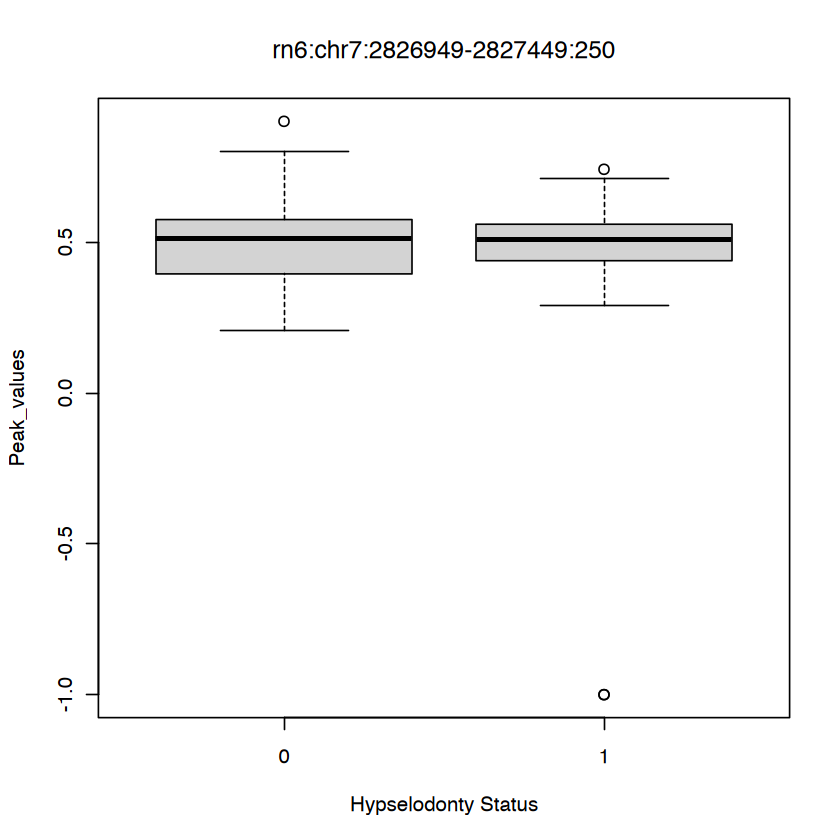

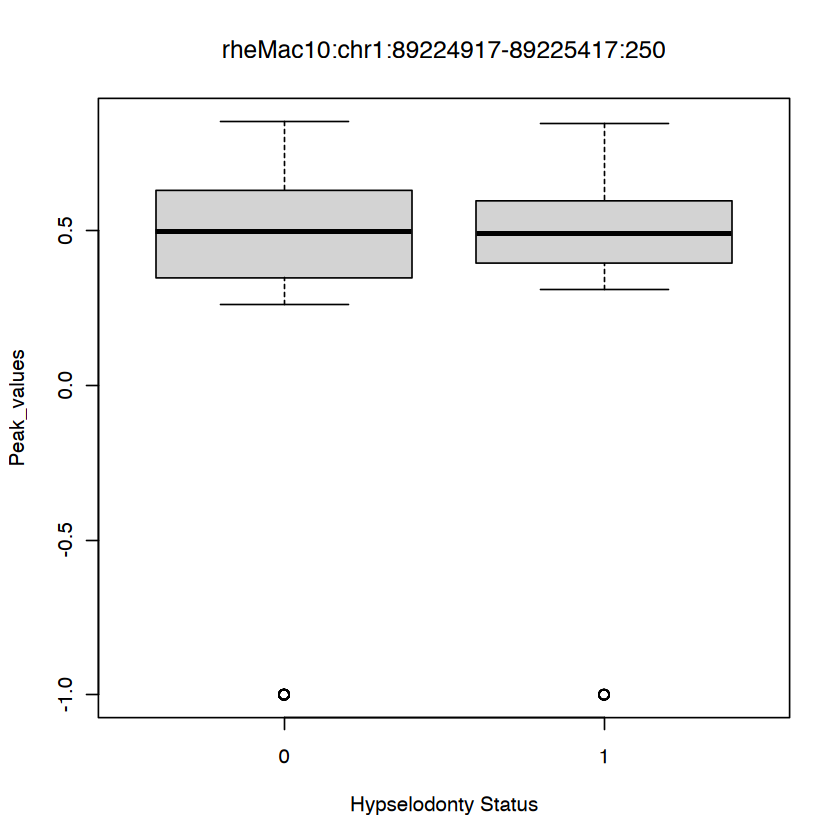

In [72]:
# Create side-by-side boxplots

boxplot(peak1_nonhyps_vector, peak1_hyps_vector, names = c("0", "1"),
        xlab = "Hypselodonty Status", ylab = "Peak_values", main = "rn6:chr7:2826949-2827449:250")

# Create side-by-side boxplots
boxplot(peak2_nonhyps_vector, peak2_hyps_vector, names = c("0", "1"),
        xlab = "Hypselodonty Status", ylab = "Peak_values", main = "rheMac10:chr1:89224917-89225417:250")


### Create BED file for GREAT (Python kernel)

In [1]:
#code for cleaning BED files
#USE PYTHON KERNEL FOR THIS
import sys
import re

filename = "phyloResNegTop.bed"
with open(filename, "r") as f:
    lines = f.readlines()

new_lines = []
for l in lines:
    l = l.strip()
    #remove quotes
    l = re.sub(r'\"', "", l)
    print(l)

    l = l.split("_")

    #ALSO SUBSET: IS THE FIRST ENTRY hg38?
    #if not, skip
    if l[0] != "hg38":
        continue
    if "250" in l:
        l=l[-4:-1]
            #if we see x, we turn it into chrx
        if l[0] == "x":
            l[0] = "chrX"
        #if we see y, we turn it into chry
        if l[0] == "y":
            l[0] = "chrY"
        new_lines.append("\t".join(l))
    else:
        l=l[-3:]
            #if we see x, we turn it into chrx
        if l[0] == "x":
            l[0] = "chrX"
        #if we see y, we turn it into chry
        if l[0] == "y":
            l[0] = "chrY"
        new_lines.append("\t".join(l))

with open(filename, "w") as f:
    #write only first 200 lines
    f.write("\n".join(new_lines[:200]))
    #f.write("\n".join(new_lines))

rn6_chr7_2826949_2827449_250
mm10_chr_x_136828556_136829057
rn6_chr7_135713270_135713770_250
rn6_chr17_63675352_63675852_250
hg38_chr1_8815512_8816013
rhe_mac10_chr6_144494360_144494860_250
mm10_chr7_134534857_134535358
hg38_chr1_18922280_18922781
rn6_chr1_170577738_170578238_250
rn6_chr8_62725636_62726136_250
rhe_mac10_chr3_25749808_25750308_250
rn6_chr15_77559459_77559959_250
rhe_mac10_chr16_51685132_51685632_250
rhe_mac10_chr7_21810775_21811275_250
mm10_chr15_99717549_99718050
rn6_chr1_261643993_261644493_250
rhe_mac10_chr11_124761153_124761653_250
rhe_mac10_chr3_176973505_176974005_250
rhe_mac10_chr_x_39642325_39642825_250
rn6_chr2_8957175_8957675_250
rhe_mac10_chr13_5626420_5626920_250
rhe_mac10_chr19_48630820_48631320_250
rhe_mac10_chr7_137990116_137990616_250
rhe_mac10_chr9_24327216_24327716_250
rhe_mac10_chr9_122943776_122944276_250
rn6_chr6_54659984_54660484_250
rn6_chr_x_158857080_158857580_250
mm10_chr4_149910020_149910521
rn6_chr10_38445235_38445735_250
rn6_chr12_6980628_69

In [2]:
#code for cleaning BED files
#USE PYTHON KERNEL FOR THIS
import sys
import re

filename = "phyloResPosTop.bed"
with open(filename, "r") as f:
    lines = f.readlines()

new_lines = []
for l in lines:
    l = l.strip()
    #remove quotes
    l = re.sub(r'\"', "", l)
    print(l)

    l = l.split("_")

    #ALSO SUBSET: IS THE FIRST ENTRY hg38?
    #if not, skip
    if l[0] != "hg38":
        continue
    if "250" in l:
        l=l[-4:-1]
            #if we see x, we turn it into chrx
        if l[0] == "x":
            l[0] = "chrX"
        #if we see y, we turn it into chry
        if l[0] == "y":
            l[0] = "chrY"
        new_lines.append("\t".join(l))
    else:
        l=l[-3:]
            #if we see x, we turn it into chrx
        if l[0] == "x":
            l[0] = "chrX"
        #if we see y, we turn it into chry
        if l[0] == "y":
            l[0] = "chrY"
        new_lines.append("\t".join(l))

with open(filename, "w") as f:
    #write only first 200 lines
    f.write("\n".join(new_lines[:200]))
    #f.write("\n".join(new_lines))

rhe_mac10_chr1_89224917_89225417_250
rn6_chr17_4696685_4697185_250
hg38_chr4_77203544_77204045
hg38_chr15_85037620_85038121
rhe_mac10_chr10_67709120_67709620_250
rn6_chr8_23917053_23917553_250
rn6_chr1_203523489_203523989_250
rhe_mac10_chr9_97513934_97514434_250
rhe_mac10_chr10_42134865_42135365_250
rn6_chr18_71050342_71050842_250
rn6_chr1_167345326_167345826_250
rn6_chr5_105563782_105564282_250
rhe_mac10_chr8_18825611_18826111_250
rhe_mac10_chr16_37644003_37644503_250
rhe_mac10_chr17_945584_946084_250
hg38_chr13_25169212_25169713
rn6_chr4_115133406_115133906_250
hg38_chr17_59155380_59155881
rn6_chr5_126173316_126173816_250
mm10_chr6_124828270_124828771
rhe_mac10_chr11_7001080_7001580_250
rn6_chr5_78335396_78335896_250
rn6_chr1_266084968_266085468_250
rn6_chr20_44563780_44564280_250
mm10_chr4_107178360_107178861
mm10_chr9_80161407_80161908
mm10_chr10_71267456_71267957
mm10_chr18_55121935_55122436
rhe_mac10_chr6_10069835_10070335_250
rn6_chr1_259381318_259381818_250
mm10_chr7_115371070_

In [3]:
#code for cleaning BED files
#USE PYTHON KERNEL FOR THIS
import sys
import re

filename = "phyloResAll.bed"
with open(filename, "r") as f:
    lines = f.readlines()

new_lines = []
for l in lines:
    l = l.strip()
    #remove quotes
    l = re.sub(r'\"', "", l)
    print(l)

    l = l.split("_")

    #ALSO SUBSET: IS THE FIRST ENTRY hg38?
    #if not, skip
    if l[0] != "hg38":
        continue
    if "250" in l:
        l=l[-4:-1]
            #if we see x, we turn it into chrx
        if l[0] == "x":
            l[0] = "chrX"
        #if we see y, we turn it into chry
        if l[0] == "y":
            l[0] = "chrY"
        new_lines.append("\t".join(l))
    else:
        l=l[-3:]
            #if we see x, we turn it into chrx
        if l[0] == "x":
            l[0] = "chrX"
        #if we see y, we turn it into chry
        if l[0] == "y":
            l[0] = "chrY"
        new_lines.append("\t".join(l))

with open(filename, "w") as f:
    #write only first 200 lines
    # f.write("\n".join(new_lines[:200]))
    f.write("\n".join(new_lines))

rn6_chr7_2826949_2827449_250
mm10_chr_x_136828556_136829057
rn6_chr7_135713270_135713770_250
rn6_chr17_63675352_63675852_250
hg38_chr1_8815512_8816013
rhe_mac10_chr6_144494360_144494860_250
mm10_chr7_134534857_134535358
hg38_chr1_18922280_18922781
rn6_chr1_170577738_170578238_250
rn6_chr8_62725636_62726136_250
rhe_mac10_chr3_25749808_25750308_250
rhe_mac10_chr1_89224917_89225417_250
rn6_chr15_77559459_77559959_250
rhe_mac10_chr16_51685132_51685632_250
rn6_chr17_4696685_4697185_250
rhe_mac10_chr7_21810775_21811275_250
mm10_chr15_99717549_99718050
rn6_chr1_261643993_261644493_250
rhe_mac10_chr11_124761153_124761653_250
hg38_chr4_77203544_77204045
rhe_mac10_chr3_176973505_176974005_250
rhe_mac10_chr_x_39642325_39642825_250
rn6_chr2_8957175_8957675_250
hg38_chr15_85037620_85038121
rhe_mac10_chr13_5626420_5626920_250
rhe_mac10_chr19_48630820_48631320_250
rhe_mac10_chr7_137990116_137990616_250
rhe_mac10_chr9_24327216_24327716_250
rhe_mac10_chr9_122943776_122944276_250
rhe_mac10_chr10_6770912